# Build reference atlas from scratch

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import copy as cp
import seaborn as sns

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=1000, frameon=False)
sc.set_figure_params(dpi=1000)
sc.set_figure_params(figsize=(7,7))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

### Download raw Dataset

In [4]:
# url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
# output = 'pbmc.h5ad'
# gdown.download(url, output, quiet=False)

In [5]:
adata = sc.read('pbmc.h5ad')

In [6]:
adata.X = adata.layers["counts"].copy()

In [7]:
adata = adata[adata.obs.study != "Villani"]

We now split the data into reference and query dataset to simulate the building process. Here we use the '10X' batch as query data.

In [8]:
target_conditions = ["10X"]
source_adata = adata[~adata.obs.study.isin(target_conditions)].copy()
target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
print(source_adata)
print(target_adata)

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'


For a better model performance it is necessary to select HVGs. We are doing this by applying the scanpy.pp function highly_variable_genes(). The n_top_genes is set to 2000 here. Howeever, if you more complicated datasets you might have to  increase number of genes to capture more diversity in the data.

In [9]:
source_adata.raw = source_adata

In [10]:
source_adata

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [11]:
sc.pp.normalize_total(source_adata)

In [12]:
sc.pp.log1p(source_adata)

In [13]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="study",
    subset=True)

For consistency we set adata.X to be raw counts. In other datasets that may be already the case

In [14]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

### Create SCVI model and train it on reference dataset

Remember that the adata file has to have count data in adata.X for SCVI/SCANVI if not further specified.

In [15]:
sca.models.SCVI.setup_anndata(source_adata, batch_key="batch")

Create the SCVI model instance with ZINB loss as default. Insert "gene_likelihood='nb'," to change the reconstruction loss to NB loss.

In [16]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [17]:
vae.train(max_epochs=80)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 80/80: 100%|██████████████████| 80/80 [01:35<00:00,  1.19s/it, loss=565, v_num=1]


The resulting latent representation of the data can then be visualized with UMAP

In [18]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
reference_latent.obs["batch"] = source_adata.obs["batch"].tolist()
reference_latent.obs["study"] = source_adata.obs["study"].tolist()

In [19]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)


In [20]:
reference_latent.obs['study'] = reference_latent.obs['study'].astype('category')

# Reorder categories, so smallest dataset is plotted on top
reference_latent.obs['study'].cat.reorder_categories(['Oetjen', 'Sun', 'Freytag'], inplace=True)

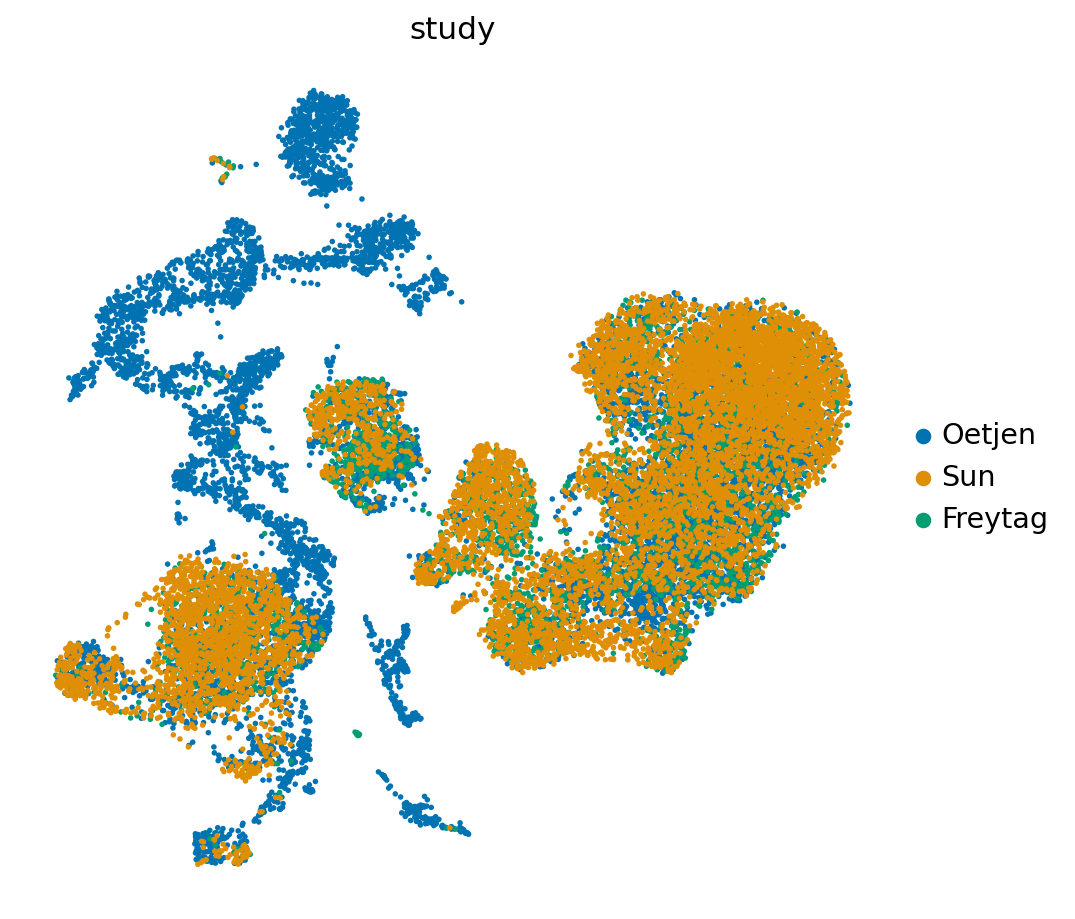

In [21]:
sc.pl.umap(reference_latent,
           color=['study'],
           frameon=False,
           wspace=0.6, s=25, 
           palette=sns.color_palette('colorblind', as_cmap=True)[:3],
           save='study.pdf'
           )

In [22]:
## The colorblind color map contains 10 different colors
## --> Rename cell types to lower resolution for the plot

reference_latent.obs['ct_low'] = 0

idx = ((reference_latent.obs.cell_type == 'CD4+ T cells') | 
       (reference_latent.obs.cell_type == 'CD8+ T cells'))
reference_latent.obs['ct_low'][idx] = 'T cells'

idx = ((reference_latent.obs.cell_type == 'CD10+ B cells') | 
       (reference_latent.obs.cell_type == 'CD20+ B cells'))
reference_latent.obs['ct_low'][idx] = 'B cells'

idx = ((reference_latent.obs.cell_type == 'CD14+ Monocytes') | 
       (reference_latent.obs.cell_type == 'CD16+ Monocytes') |
       (reference_latent.obs.cell_type == 'Monocyte progenitors'))
reference_latent.obs['ct_low'][idx] = 'Monocytes'

idx = ((reference_latent.obs.cell_type == 'Erythrocytes') | 
       (reference_latent.obs.cell_type == 'Erythroid progenitors'))
reference_latent.obs['ct_low'][idx] = 'Erythrocytes'

idx = ((reference_latent.obs.cell_type == 'Monocyte-derived dendritic cells') | 
       (reference_latent.obs.cell_type == 'Plasmacytoid dendritic cells'))
reference_latent.obs['ct_low'][idx] = 'Dendritic cells'

idx = reference_latent.obs.cell_type == 'HSPCs'
reference_latent.obs['ct_low'][idx] = 'HSPCs'

idx = reference_latent.obs.cell_type == 'Megakaryocyte progenitors'
reference_latent.obs['ct_low'][idx] = 'Megakaryocyte progenitors'

idx = reference_latent.obs.cell_type == 'NK cells'
reference_latent.obs['ct_low'][idx] = 'NK cells'

idx = reference_latent.obs.cell_type == 'NKT cells'
reference_latent.obs['ct_low'][idx] = 'NKT cells'

idx = reference_latent.obs.cell_type == 'Plasma cells'
reference_latent.obs['ct_low'][idx] = 'Plasma cells'


/tmp/ipykernel_725642/2368197161.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_latent.obs['ct_low'][idx] = 'T cells'


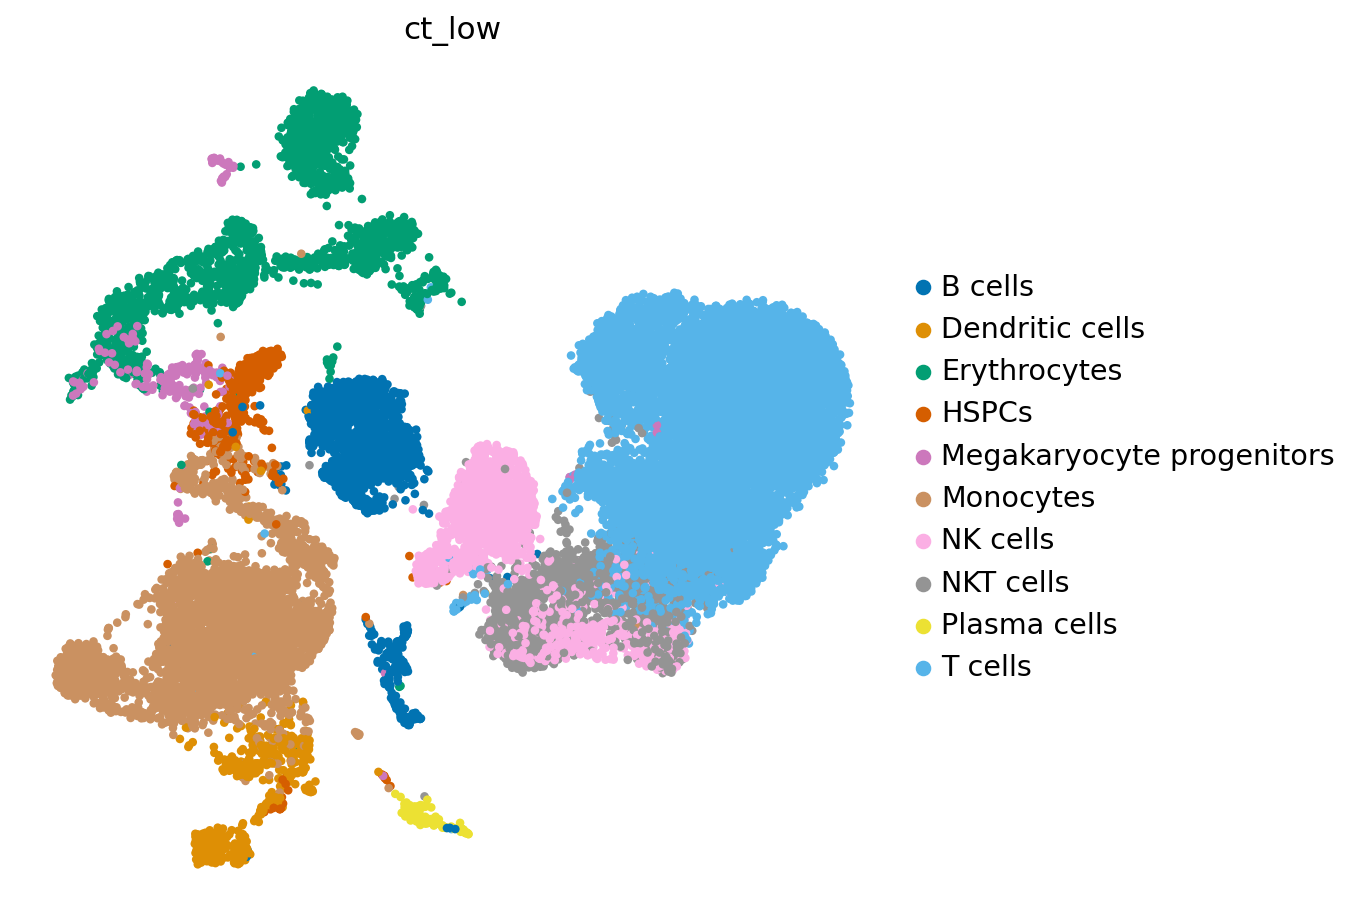

In [23]:
sc.pl.umap(reference_latent,
           color=['ct_low'], 
           frameon=False,
           wspace=0.6, s=60, 
           palette=sns.color_palette('colorblind', as_cmap=True),
           save='ref_cp.pdf'
           )

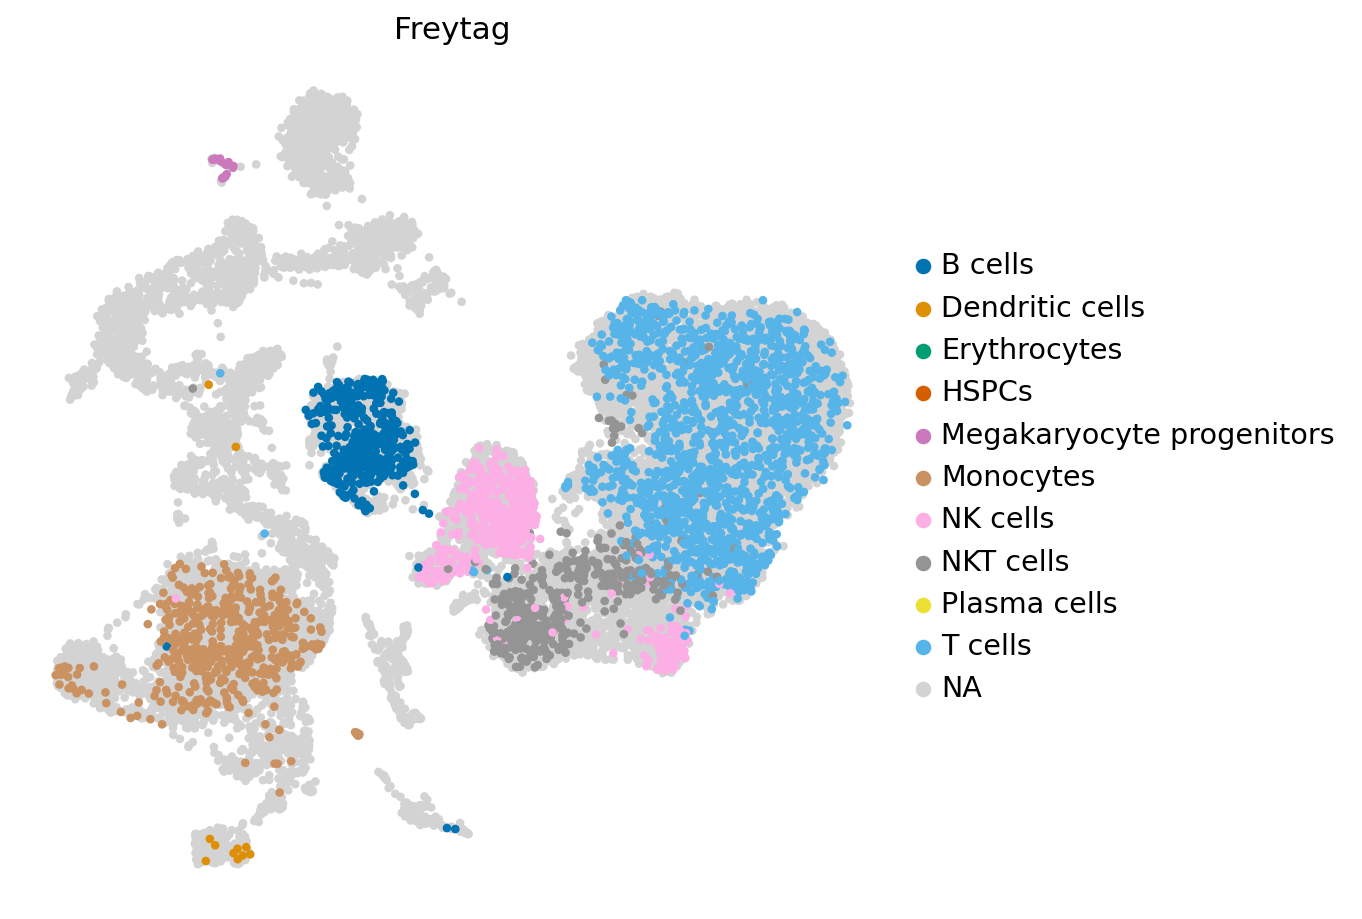

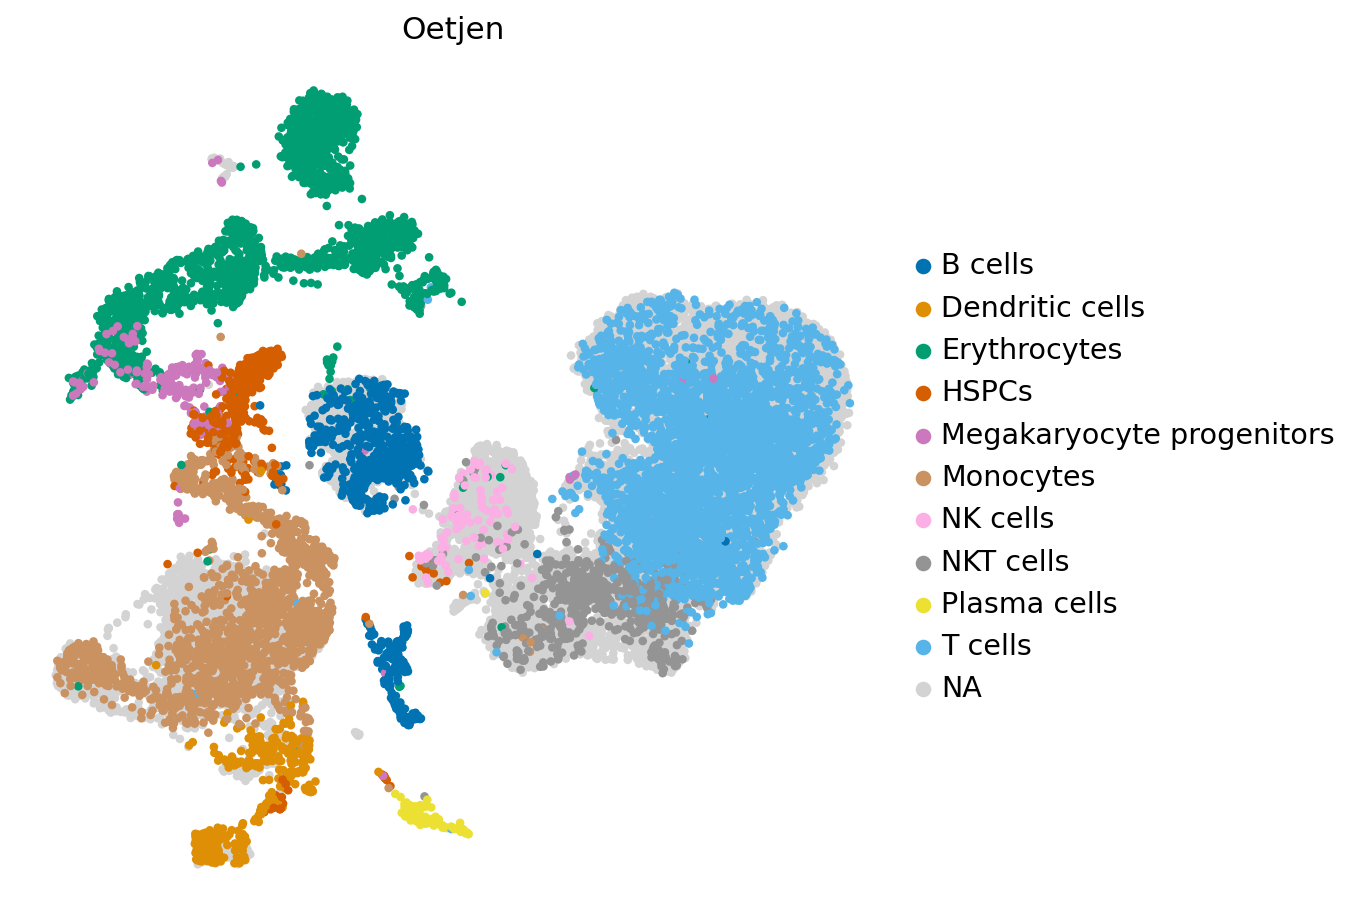

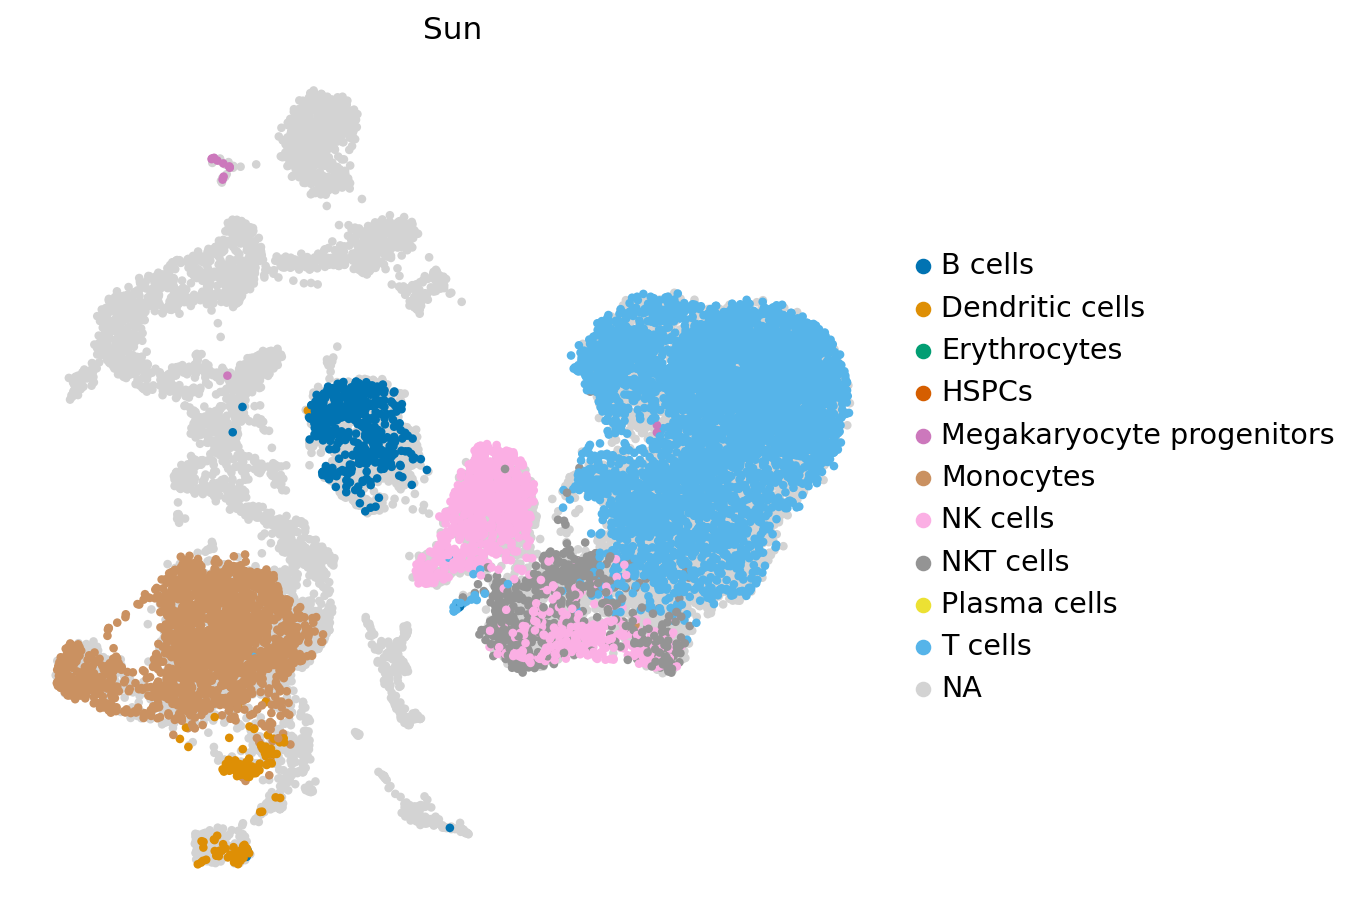

In [24]:
# We can also visualize the cell populations per dataset
for s in np.unique(reference_latent.obs.study):
    ref_s = cp.deepcopy(reference_latent)
    ref_s.obs.ct_low[reference_latent.obs.study != s] = np.nan

    sc.pl.umap(ref_s,
               color=['ct_low'], 
               frameon=False,
               wspace=0.6, s=60, 
               palette=sns.color_palette('colorblind', as_cmap=True), title=s,
               save=s+'.pdf'
               )

After pretraining the model can be saved for later use or also be uploaded for other researchers with via Zenodo. For the second option please also have a look at the Zenodo notebook.

In [25]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)
reference_latent.write(ref_path + 'ref_latent.h5ad')

### Construct hierarchy for the reference using scHPL

We first have to concatenate all cell type labels with the study labels. This way, we ensure that the cell types of the different studies are seen as unique.

In [26]:
reference_latent.obs['celltype_batch'] = np.char.add(np.char.add(np.array(reference_latent.obs['cell_type'], dtype= str), '-'),
                                             np.array(reference_latent.obs['study'], dtype=str))

Starting tree:


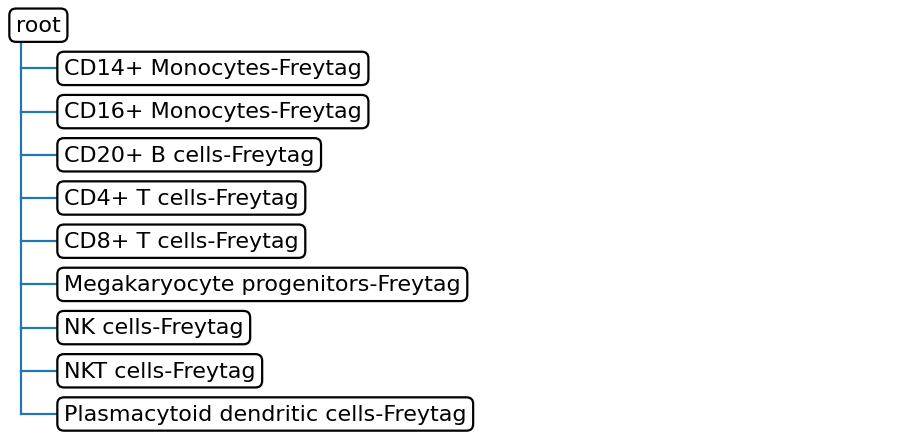


Adding dataset Oetjen to the tree

Updated tree:


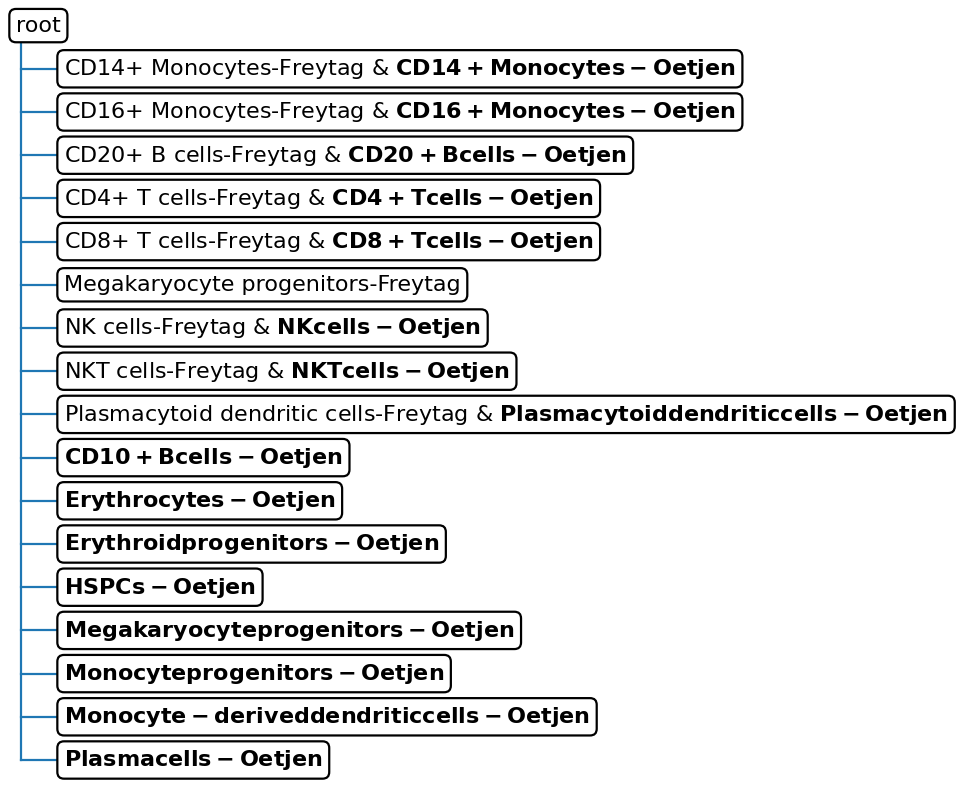


Adding dataset Sun to the tree

Updated tree:


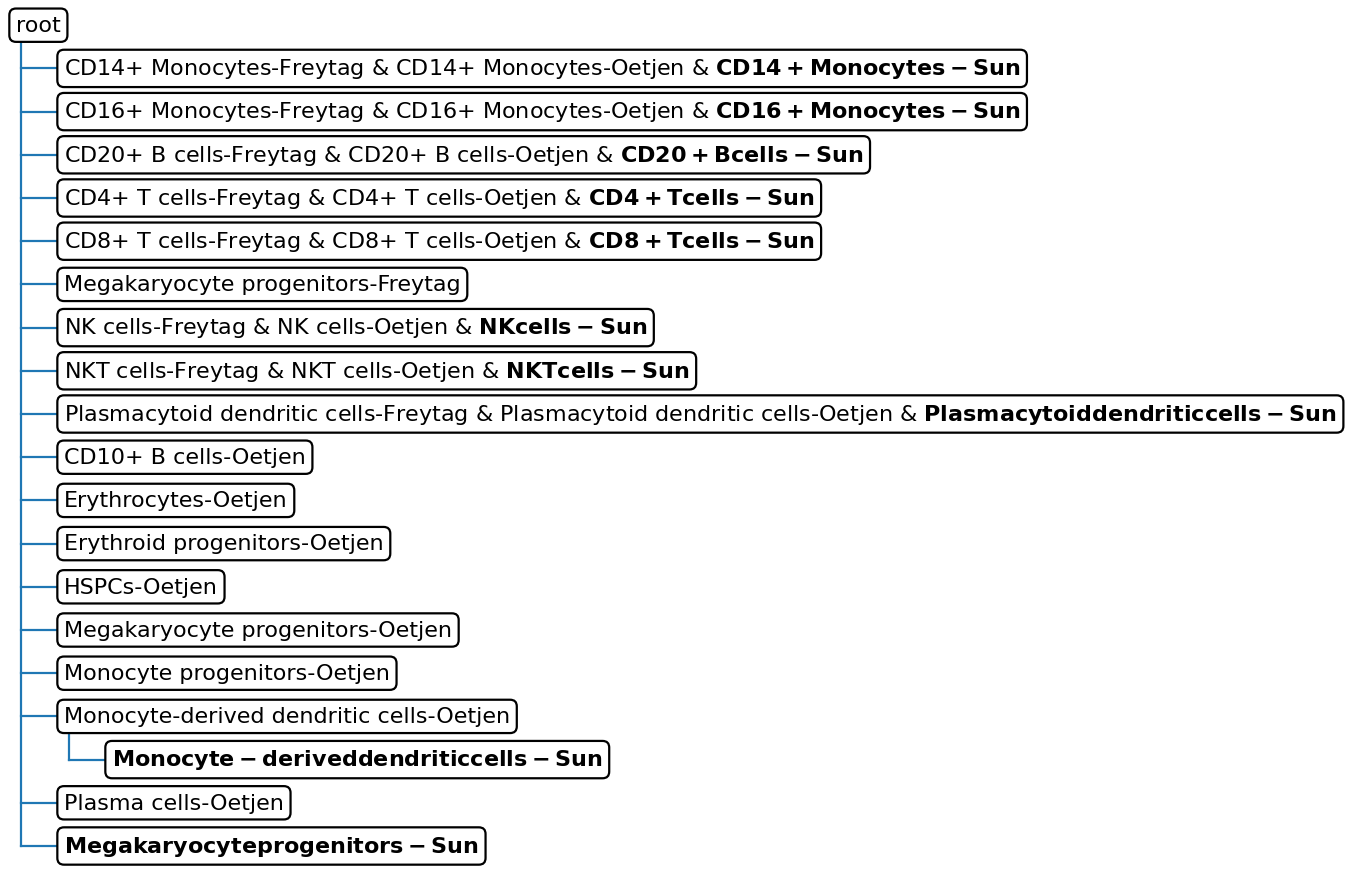

In [27]:
tree_ref, mp_ref = sca.classifiers.scHPL.learn_tree(data = reference_latent, 
                batch_key = 'study',
                batch_order = ['Freytag', 'Oetjen', 'Sun'],
                cell_type_key='celltype_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)


### Use pretrained reference model and apply surgery with a new query dataset to get a bigger reference atlas

Since the model requires the datasets to have the same genes we also filter the query dataset to have the same genes as the reference dataset.

In [28]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

We then can apply the model surgery with the new query dataset:

In [29]:
target_adata = target_adata.copy()

In [30]:
model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)

INFO     File ref_model/model.pt already downloaded                                          


In [31]:
model.train(max_epochs=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████████████| 50/50 [00:26<00:00,  1.88it/s, loss=975, v_num=1]


In [32]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs["final_annotation"].tolist()
query_latent.obs['batch'] = target_adata.obs["batch"].tolist()

And again we can save or upload the retrained model for later use or additional extensions.

In [33]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)
query_latent.write('query_latent.h5ad')

### Get latent representation of reference + query dataset and compute UMAP

In [34]:
target_adata.obs.study = "10X"

In [35]:
target_adata

AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'counts'

In [36]:
adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_scvi_batch', '_scvi_labels', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [37]:
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()
full_latent.obs['study'] = adata_full.obs["study"].tolist()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


In [38]:
full_latent.obs['celltype_batch'] = np.char.add(np.char.add(np.array(full_latent.obs['cell_type'], dtype= str), '-'),
                                             np.array(full_latent.obs['study'], dtype=str))

In [39]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

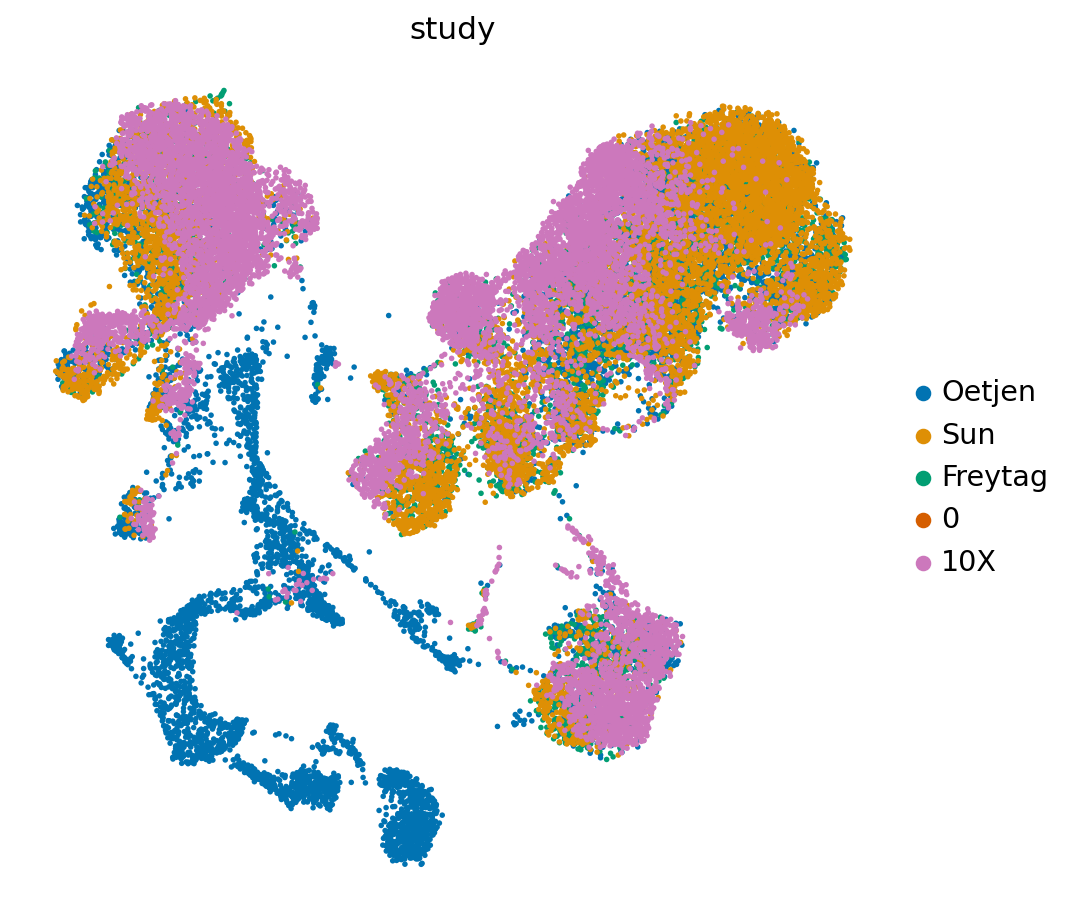

In [40]:
full_latent.obs['study'] = full_latent.obs['study'].astype('category')
full_latent.obs['study'].cat.add_categories(['0'], inplace=True)
full_latent.obs['study'].cat.reorder_categories(['Oetjen', 'Sun', 'Freytag', '0', '10X'], inplace=True)

sc.pl.umap(full_latent,
           color=['study'],
           frameon=False,
           wspace=0.6, s=25, 
           palette=sns.color_palette('colorblind', as_cmap=True)[:5],
           save='study_query.pdf'
           )

In [41]:
full_latent.obs['ct_low'] = 0

idx = ((full_latent.obs.cell_type == 'CD4+ T cells') | 
       (full_latent.obs.cell_type == 'CD8+ T cells'))
full_latent.obs['ct_low'][idx] = 'T cells'

idx = ((full_latent.obs.cell_type == 'CD10+ B cells') | 
       (full_latent.obs.cell_type == 'CD20+ B cells'))
full_latent.obs['ct_low'][idx] = 'B cells'

idx = ((full_latent.obs.cell_type == 'CD14+ Monocytes') | 
       (full_latent.obs.cell_type == 'CD16+ Monocytes') |
       (full_latent.obs.cell_type == 'Monocyte progenitors'))
full_latent.obs['ct_low'][idx] = 'Monocytes'

idx = ((full_latent.obs.cell_type == 'Erythrocytes') | 
       (full_latent.obs.cell_type == 'Erythroid progenitors'))
full_latent.obs['ct_low'][idx] = 'Erythrocytes'

idx = ((full_latent.obs.cell_type == 'Monocyte-derived dendritic cells') | 
       (full_latent.obs.cell_type == 'Plasmacytoid dendritic cells'))
full_latent.obs['ct_low'][idx] = 'Dendritic cells'

idx = full_latent.obs.cell_type == 'HSPCs'
full_latent.obs['ct_low'][idx] = 'HSPCs'

idx = full_latent.obs.cell_type == 'Megakaryocyte progenitors'
full_latent.obs['ct_low'][idx] = 'Megakaryocyte progenitors'

idx = full_latent.obs.cell_type == 'NK cells'
full_latent.obs['ct_low'][idx] = 'NK cells'

idx = full_latent.obs.cell_type == 'NKT cells'
full_latent.obs['ct_low'][idx] = 'NKT cells'

idx = full_latent.obs.cell_type == 'Plasma cells'
full_latent.obs['ct_low'][idx] = 'Plasma cells'


/tmp/ipykernel_725642/1546695568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_latent.obs['ct_low'][idx] = 'T cells'


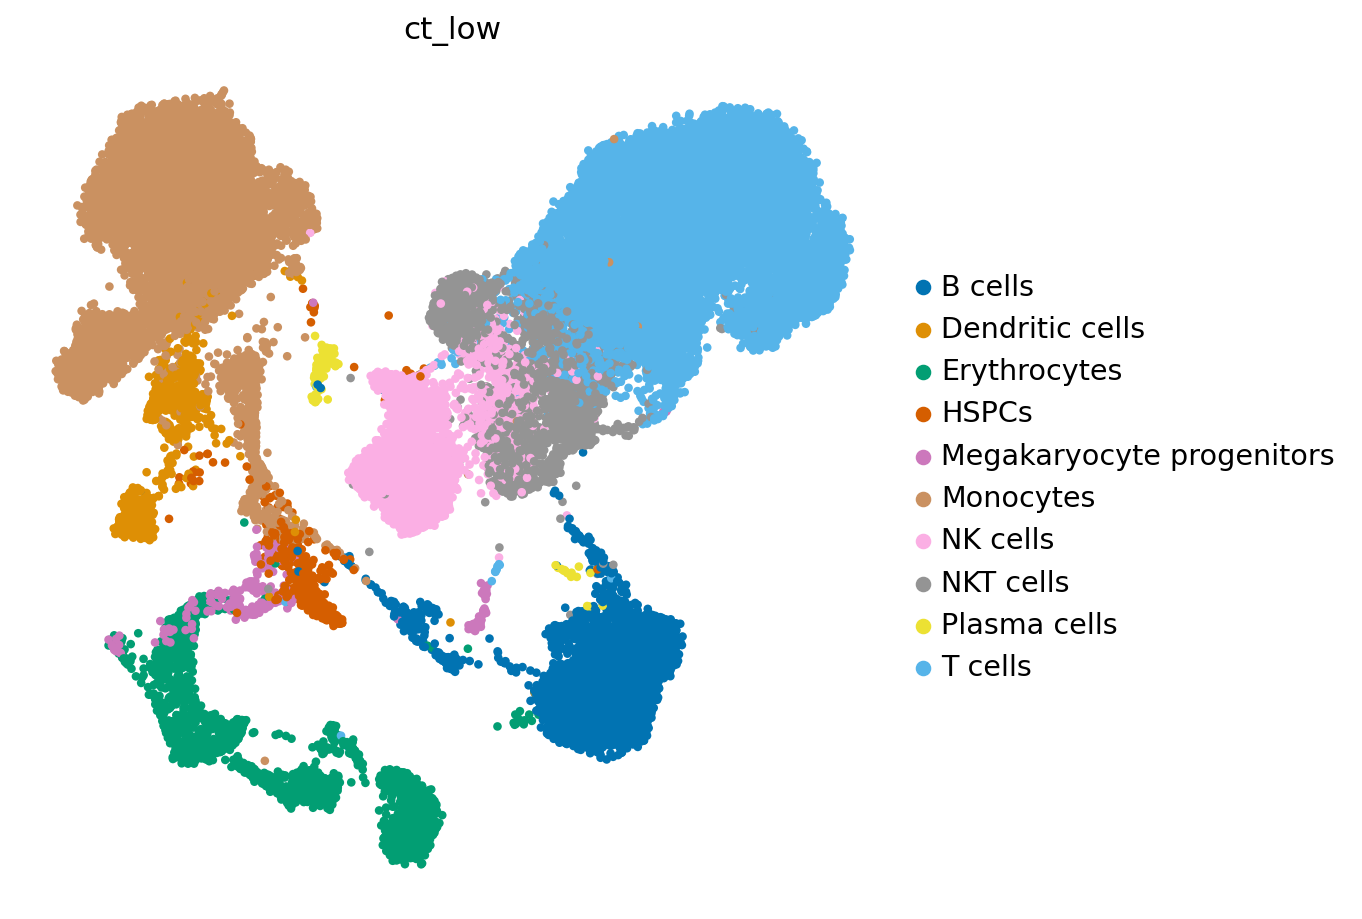

In [42]:
sc.pl.umap(full_latent,
           color=['ct_low'], 
           frameon=False,
           wspace=0.6, s=60, 
           palette=sns.color_palette('colorblind', as_cmap=True),
           save='cp_query.pdf'
           )


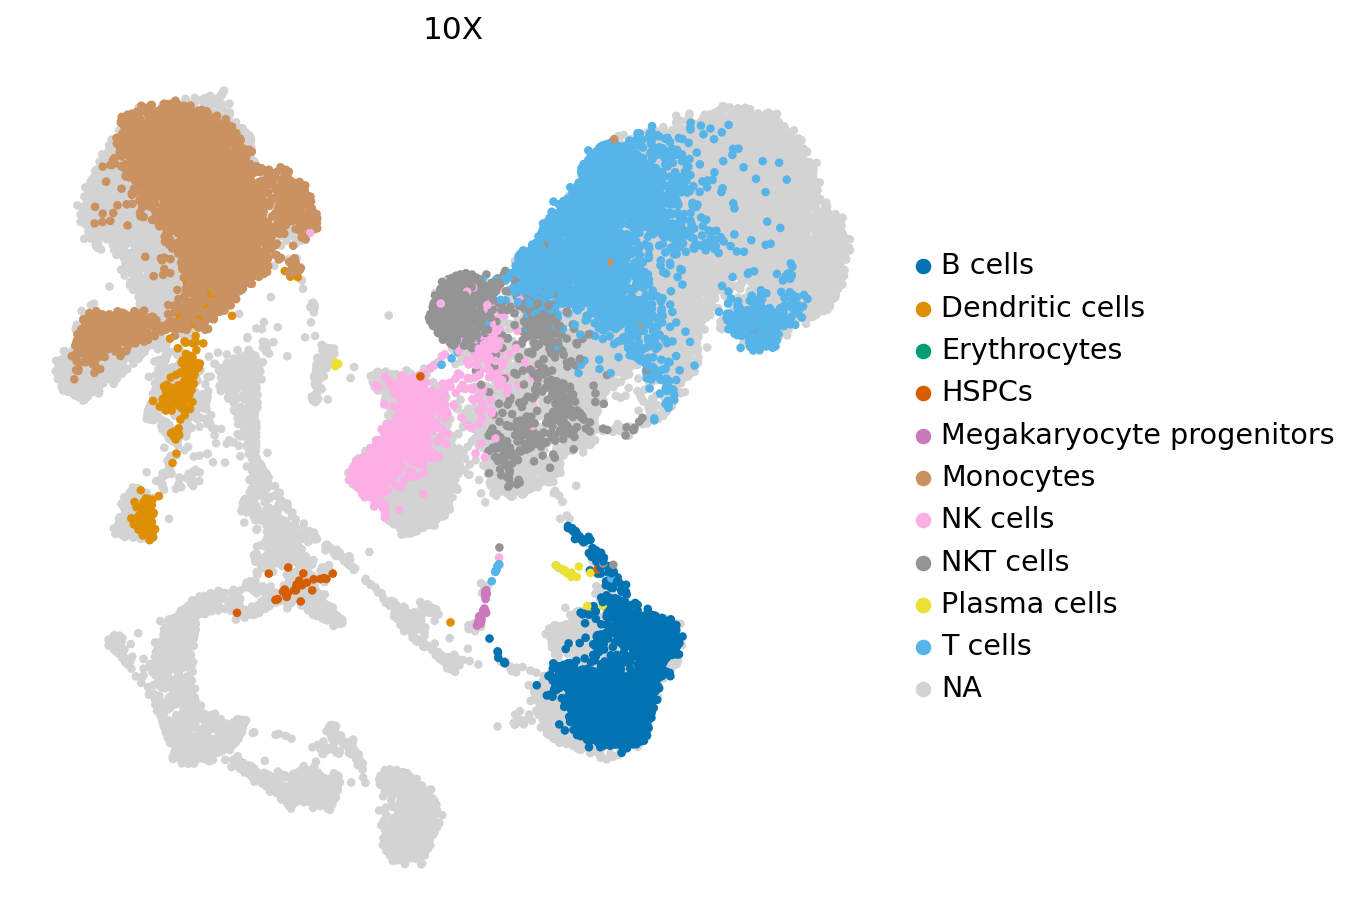

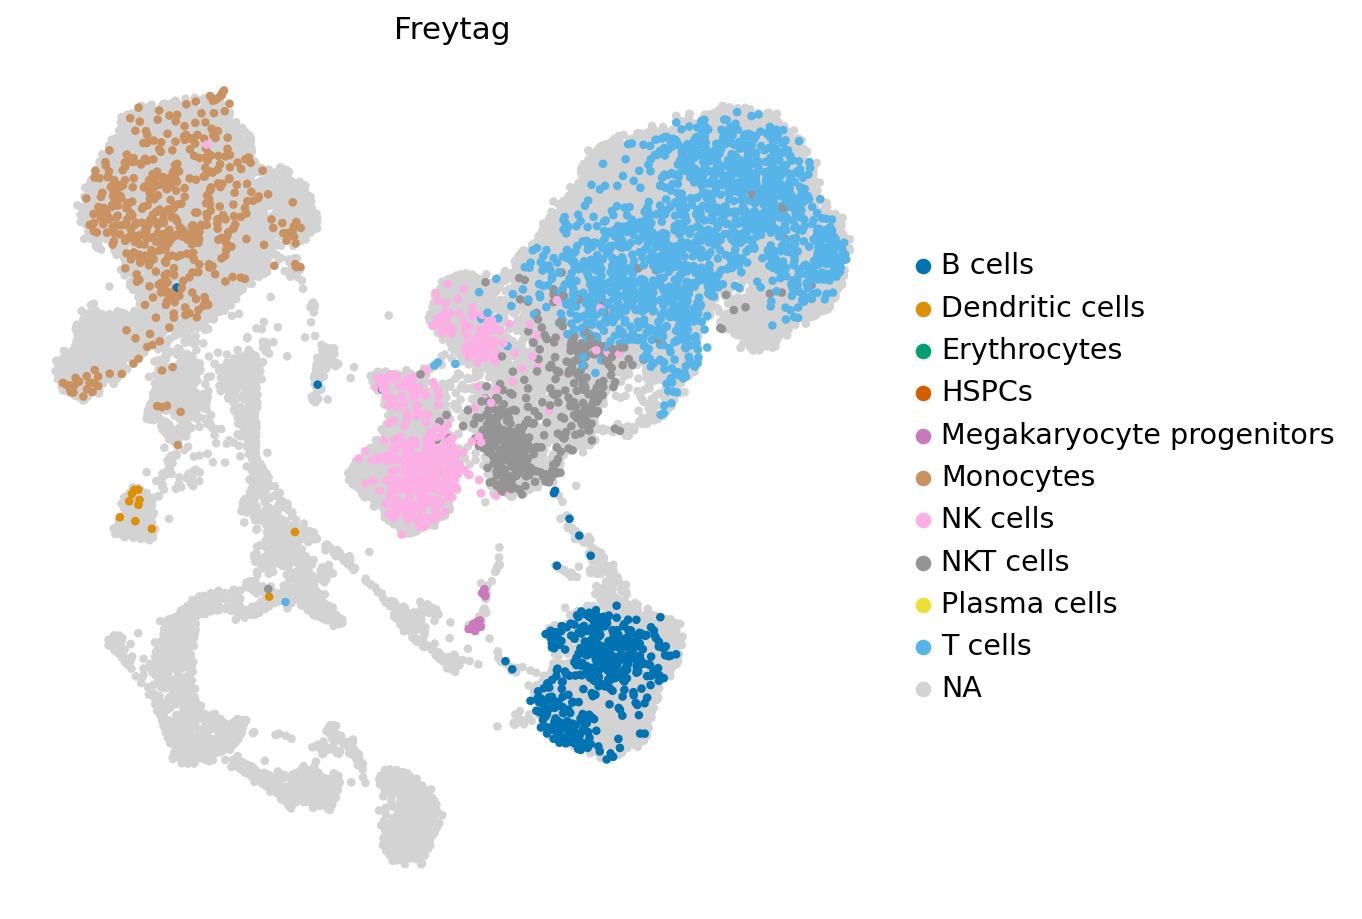

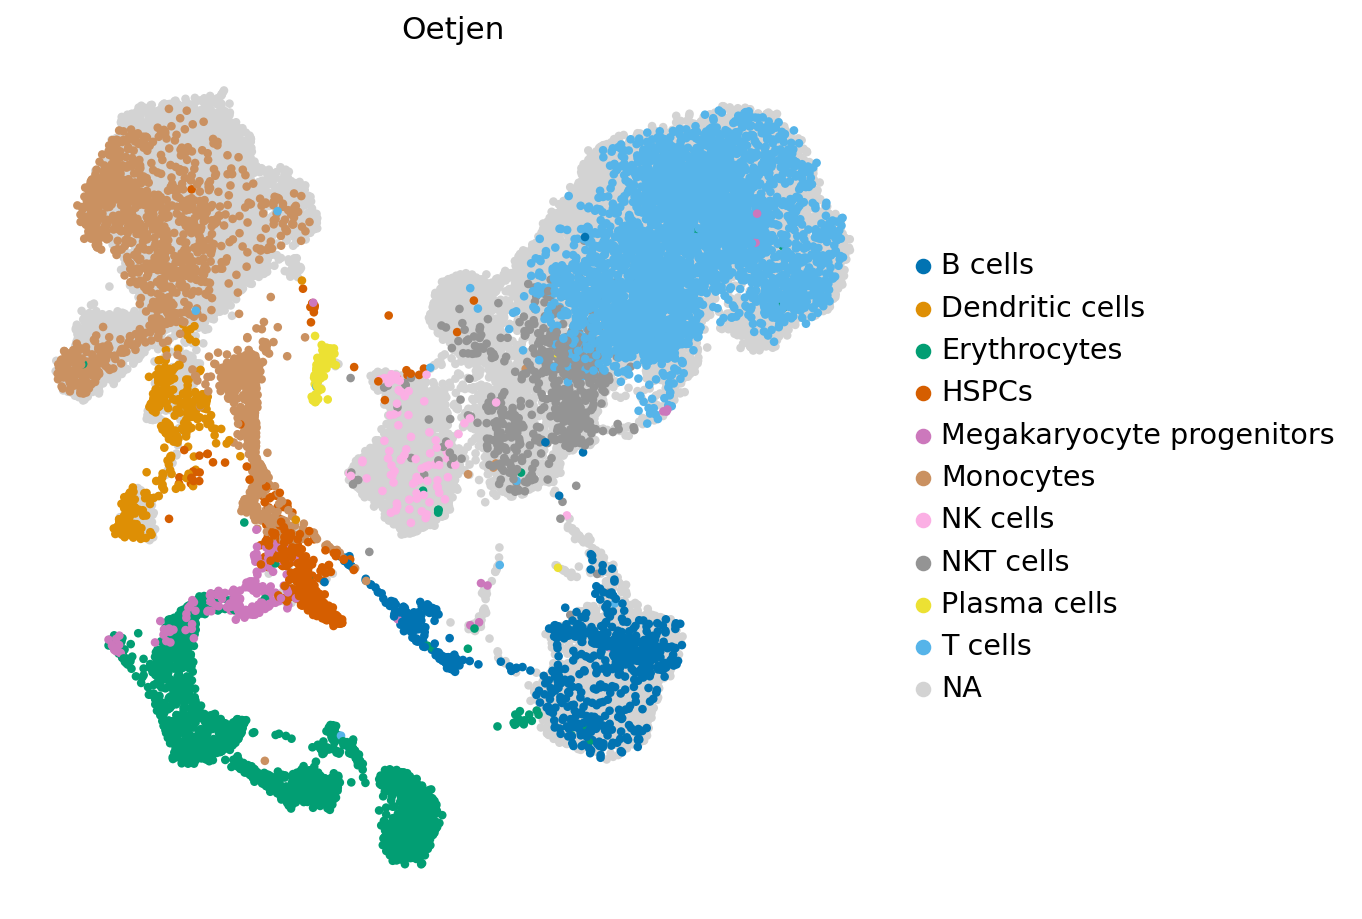

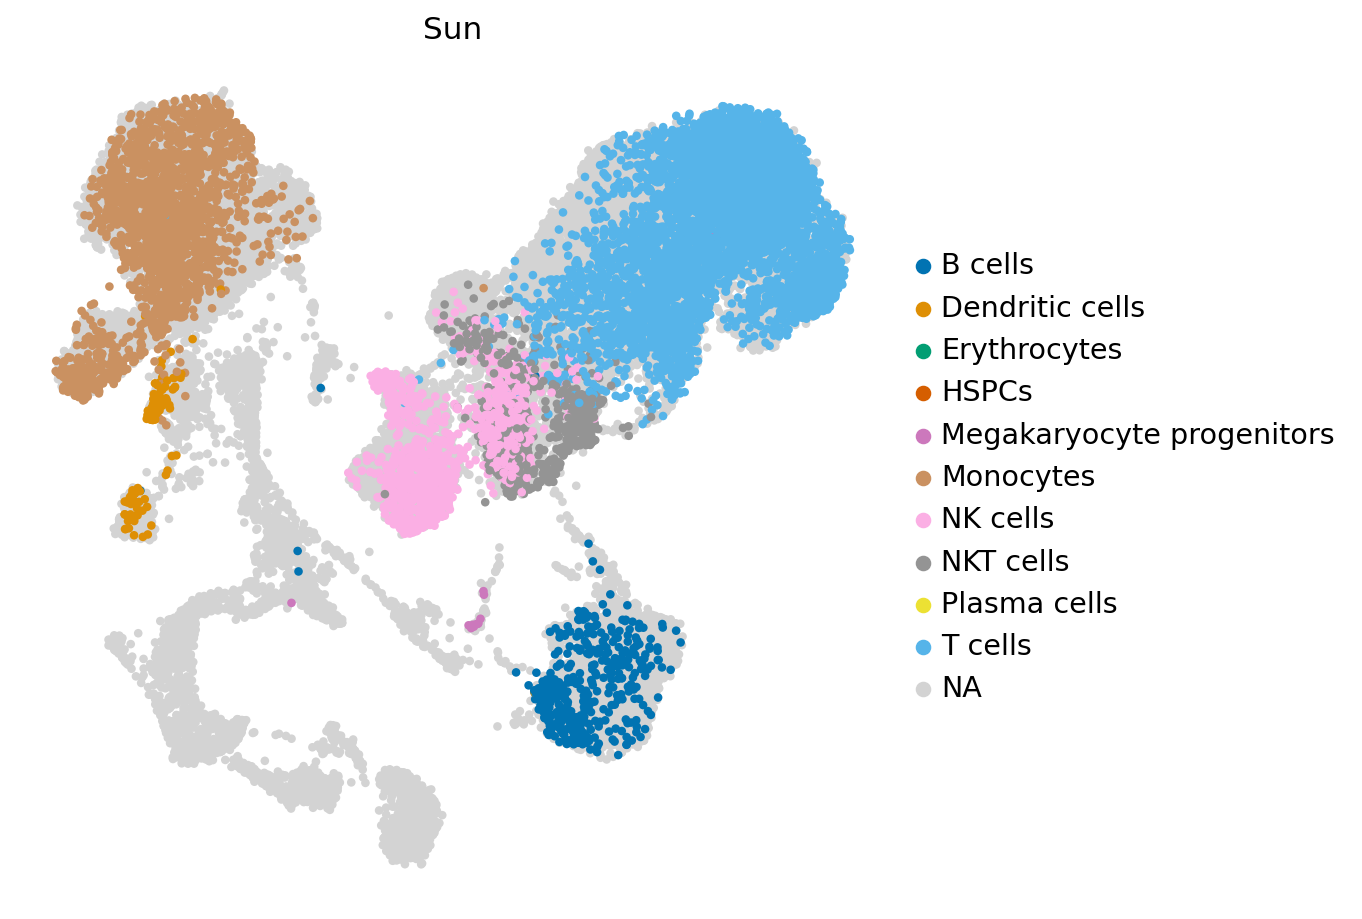

In [43]:
for s in np.unique(full_latent.obs.study):
    ref_s = cp.deepcopy(full_latent)
    ref_s.obs.ct_low[full_latent.obs.study != s] = np.nan

    sc.pl.umap(ref_s,
               color=['ct_low'], 
               frameon=False,
               wspace=0.6, s=60, 
               palette=sns.color_palette('colorblind', as_cmap=True), title=s,
               save=s+'_query.pdf'
               )


Starting tree:


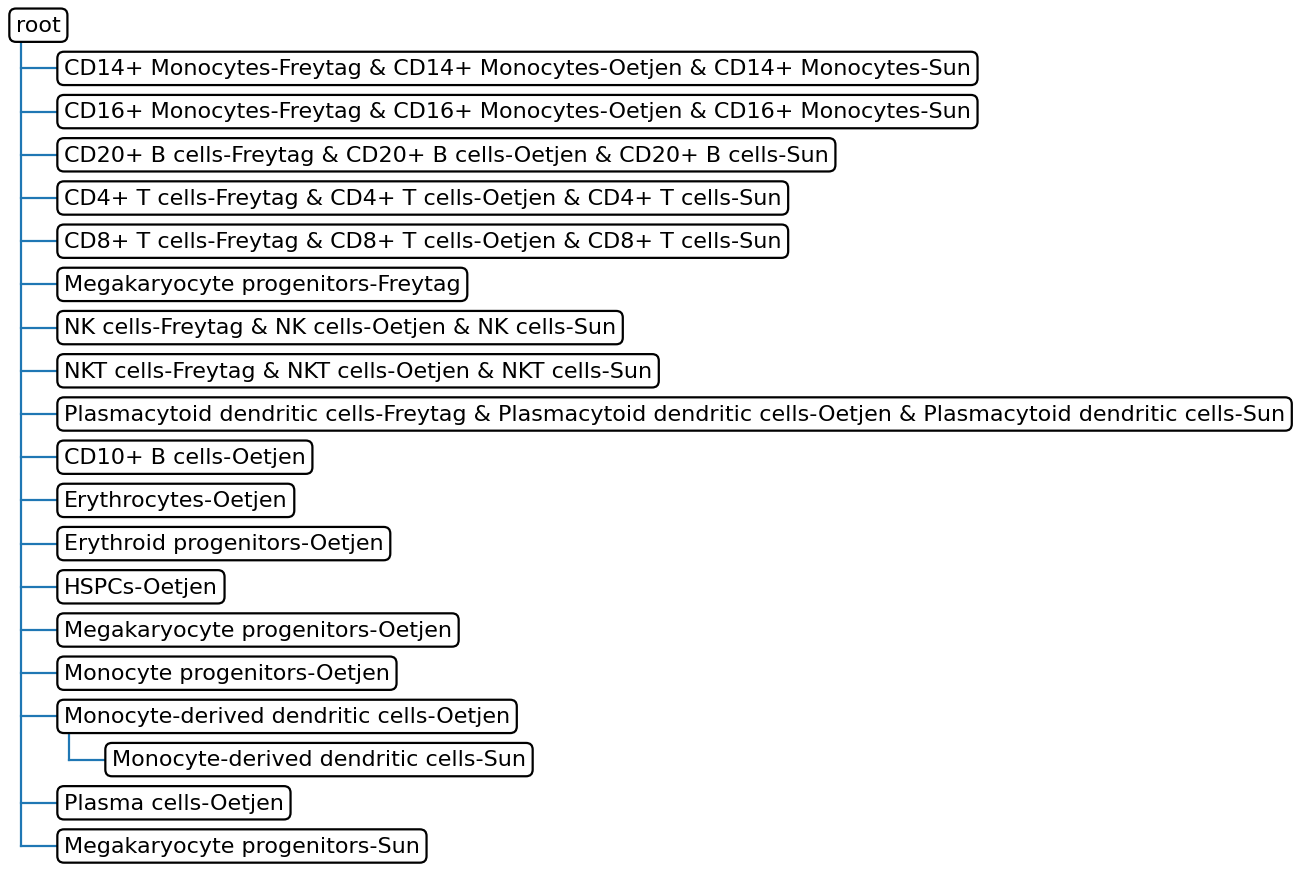


Adding dataset 10X to the tree


In [ ]:
tree_rq, mp_rq = sca.classifiers.scHPL.learn_tree(data = full_latent, batch_key = 'study',
                 batch_order = ['10X'],
                 batch_added = ['Oetjen', 'Freytag', 'Sun'],
                 cell_type_key='celltype_batch',
                 tree = tree_ref, retrain = False,
                classifier = 'knn',
                dimred = False)